In [1]:
import os
import time

import pandas as pd
import numpy as np
from dotenv import load_dotenv

from pymilvus import connections, utility, MilvusClient
from pymilvus import FieldSchema, CollectionSchema, DataType, Collection

from sentence_transformers import SentenceTransformer

In [2]:
load_dotenv()
MILVUS_HOST = os.environ['MILVUS_HOST']
MILVUS_TOKEN = os.environ['MILVUS_TOKEN']

HOST = MILVUS_HOST
TOKEN = MILVUS_TOKEN

COLLECTION_NAME_SONGS = "songs_collection"
COLLECTION_NAME_SONGS_part = "songs_collection_part"
COLLECTION_NAME_ARTISTS = "artists_collection"
COLLECTION_NAME_USERS = "users_collection"
COLLECTION_NAME_USERS_ARTISTS = "users_artists_collection"

DIMENSION = 384
BATCH_SIZE = 512

## Read and clean dataset

In [8]:
df = pd.read_csv("./dataset/Spotify Million Song Dataset_exported.csv")
df = df.dropna()

cleaned_df = df.loc[(df["text"].str.len() > 50)]
cleaned_df["text"] = cleaned_df["text"].str.replace("\n", "")

In [3]:
connections.connect("default", uri=HOST, token=TOKEN)

In [5]:
def create_songs_collection():
    if utility.has_collection(COLLECTION_NAME_SONGS):
        utility.drop_collection(COLLECTION_NAME_SONGS)

    # object should be inserted in the format of (artist, song, embedding embedding)
    fields = [
        FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=True),
        FieldSchema(name="artist", dtype=DataType.VARCHAR, max_length=100),
        FieldSchema(name="song", dtype=DataType.VARCHAR, max_length=100),
        FieldSchema(name="embedding", dtype=DataType.FLOAT_VECTOR, dim=DIMENSION)
    ]
    
    schema = CollectionSchema(fields=fields)
    collection = Collection(name=COLLECTION_NAME_SONGS, schema=schema)

    collection.create_index(field_name="embedding", 
                            index_params={
                                "index_type": "IVF_FLAT",
                                "metric_type": "L2",
                                "params": {"nlist": 128},
                            })    
    collection.load()
    return collection

In [6]:
songs_collection = create_songs_collection()

## create song embeddings

In [13]:
transformer = SentenceTransformer('all-MiniLM-L6-v2')

In [25]:
def embed_insert(data, collection):
    try:
        texts = np.array(data[2])
        embeddings = transformer.encode(texts)

        insert_data = [
            data[0],  # artist
            data[1],  # song
            embeddings.tolist()  # embeddings
        ]

        collection.insert(insert_data)
        print(f"Inserted batch of {len(data[0])} songs.")
        
        return {f"{artist}-{song}": embedding.tolist() for artist, song, embedding in zip(data[0], data[1], embeddings)}
    except Exception as e:
        print(f"Error during embedding and insertion: {e}")
        return None

In [9]:
data_batch = [[], [], []]
song_vectors = {} 

for index, row in cleaned_df.iterrows():
    data_batch[0].append(row["artist"])
    data_batch[1].append(row["song"])
    data_batch[2].append(row["text"])

    if len(data_batch[0]) % BATCH_SIZE == 0:
        batch_vectors = embed_insert(data_batch, songs_collection)
        if batch_vectors is not None:
            song_vectors.update(batch_vectors)
        data_batch = [[], [], []]

if len(data_batch[0]) != 0:
    batch_vectors = embed_insert(data_batch, songs_collection)
    if batch_vectors is not None:
        song_vectors.update(batch_vectors)

try:
    songs_collection.flush()
    print("Flushed changes to the songs collection.")
except Exception as e:
    print(f"Error during flushing the songs collection: {e}")

Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch

## Average vector of all songs by artist

In [10]:
from collections import defaultdict

start_time = time.time()
artist_vectors = defaultdict(list)

for artist_name in cleaned_df['artist'].unique():
    entities = songs_collection.query(
        expr = f'artist == "{artist_name}"',
        output_fields = ["artist", "embedding"])    
    
    for entity in entities:
        artist = entity["artist"]
        vector = entity["embedding"]
        artist_vectors[artist].append(vector)

end_time = time.time()
execution_time = end_time - start_time
print(f"The collection scanning elapsed: {execution_time} seconds")

# Calculate average vector for each artist
artist_avg_vectors = {}
for artist, vectors in artist_vectors.items():
    avg_vector = np.mean(vectors, axis=0)
    artist_avg_vectors[artist] = avg_vector

The collection scanning elapsed: 249.842383146286 seconds


In [11]:
def create_artist_collection():
    if utility.has_collection(COLLECTION_NAME_ARTISTS):
        utility.drop_collection(COLLECTION_NAME_ARTISTS)

    # object should be inserted in the format of (artist, embedding embedding)
    fields = [
        FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=True),
        FieldSchema(name="artist", dtype=DataType.VARCHAR, max_length=100),
        FieldSchema(name="embedding", dtype=DataType.FLOAT_VECTOR, dim=DIMENSION)
    ]
    
    schema = CollectionSchema(fields=fields)
    collection = Collection(name=COLLECTION_NAME_ARTISTS, schema=schema)

    index_params = {
        "index_type": "IVF_FLAT",
        "metric_type": "L2",
        "params": {"nlist": 128},
    }
    collection.create_index(field_name="embedding", index_params=index_params)
    collection.load()
    return collection

In [12]:
collection_artists = create_artist_collection()

In [14]:
data_batch = [[], []]

for key, value in artist_avg_vectors.items():
    data_batch[0].append(key)
    data_batch[1].append(value)
    
    if len(data_batch[0]) % BATCH_SIZE == 0:
        collection_artists.insert(data_batch)
        data_batch = [[], []]

if len(data_batch[0]) != 0:
    collection_artists.insert(data_batch)

try:
    collection_artists.flush()
    print("Flushed changes to the artist collection")
except Exception as e:
    print(f"Error during flushing the artist collection: {e}")

Flushed changes to the artist collection


## Test the data

In [125]:
from sklearn.metrics.pairwise import cosine_similarity
from tabulate import tabulate

def search_and_evaluate(search_terms, collection, top_k=10):
    query_embedding = transformer.encode(search_terms)
    query_embedding = np.array(query_embedding)

    search_results = collection.search(
        data=query_embedding,
        anns_field="embedding",
        param={"metric_type": "L2", "params": {"nprobe": 20}},
        limit=top_k,
        output_fields=["artist", "song", "embedding"]
    )    
    
    results = []
    similarities = []
    for hit in search_results[0]:
        artist = hit.entity.get('artist')
        song = hit.entity.get('song')
        similarity = cosine_similarity(query_embedding, np.array([hit.entity.get('embedding')]))[0][0]
        similarities.append(similarity)
        results.append([artist, song, f"{similarity:.2f}"])

    print(tabulate(results, headers=["Artist", "Song", "Similarity"]))
    average_similarity = np.mean(similarities)
    print(f"Average similarity: {average_similarity:.2f}")
    return search_results, average_similarity

# Пример использования
search_terms = "We alone battle for the true metal and stand for everyone's right to fight. Together, under the metal sky, we vow that our steel will never run dry"
results = search_and_evaluate([search_terms], songs_collection, top_k=20)


Artist        Song                                           Similarity
------------  -------------------------------------------  ------------
Manowar       Brothers Of Metal                                    0.69
Manowar       Gloves Of Metal                                      0.66
Metallica     Metal Militia                                        0.63
Manowar       The Lord Of Steel                                    0.6
Helloween     Heavy Metal                                          0.59
Manowar       Warriors Of The World                                0.59
Manowar       The God's Made Of Heavy Metal                        0.59
Manowar       Metal Warriors (brothers Of Metal Part One)          0.59
Manowar       Call To Arms                                         0.59
Manowar       Die For Metal                                        0.58
Venom         Harder Than Ever                                     0.57
Manowar       Fighting The World                                 

## Visualization of the clusters of artists

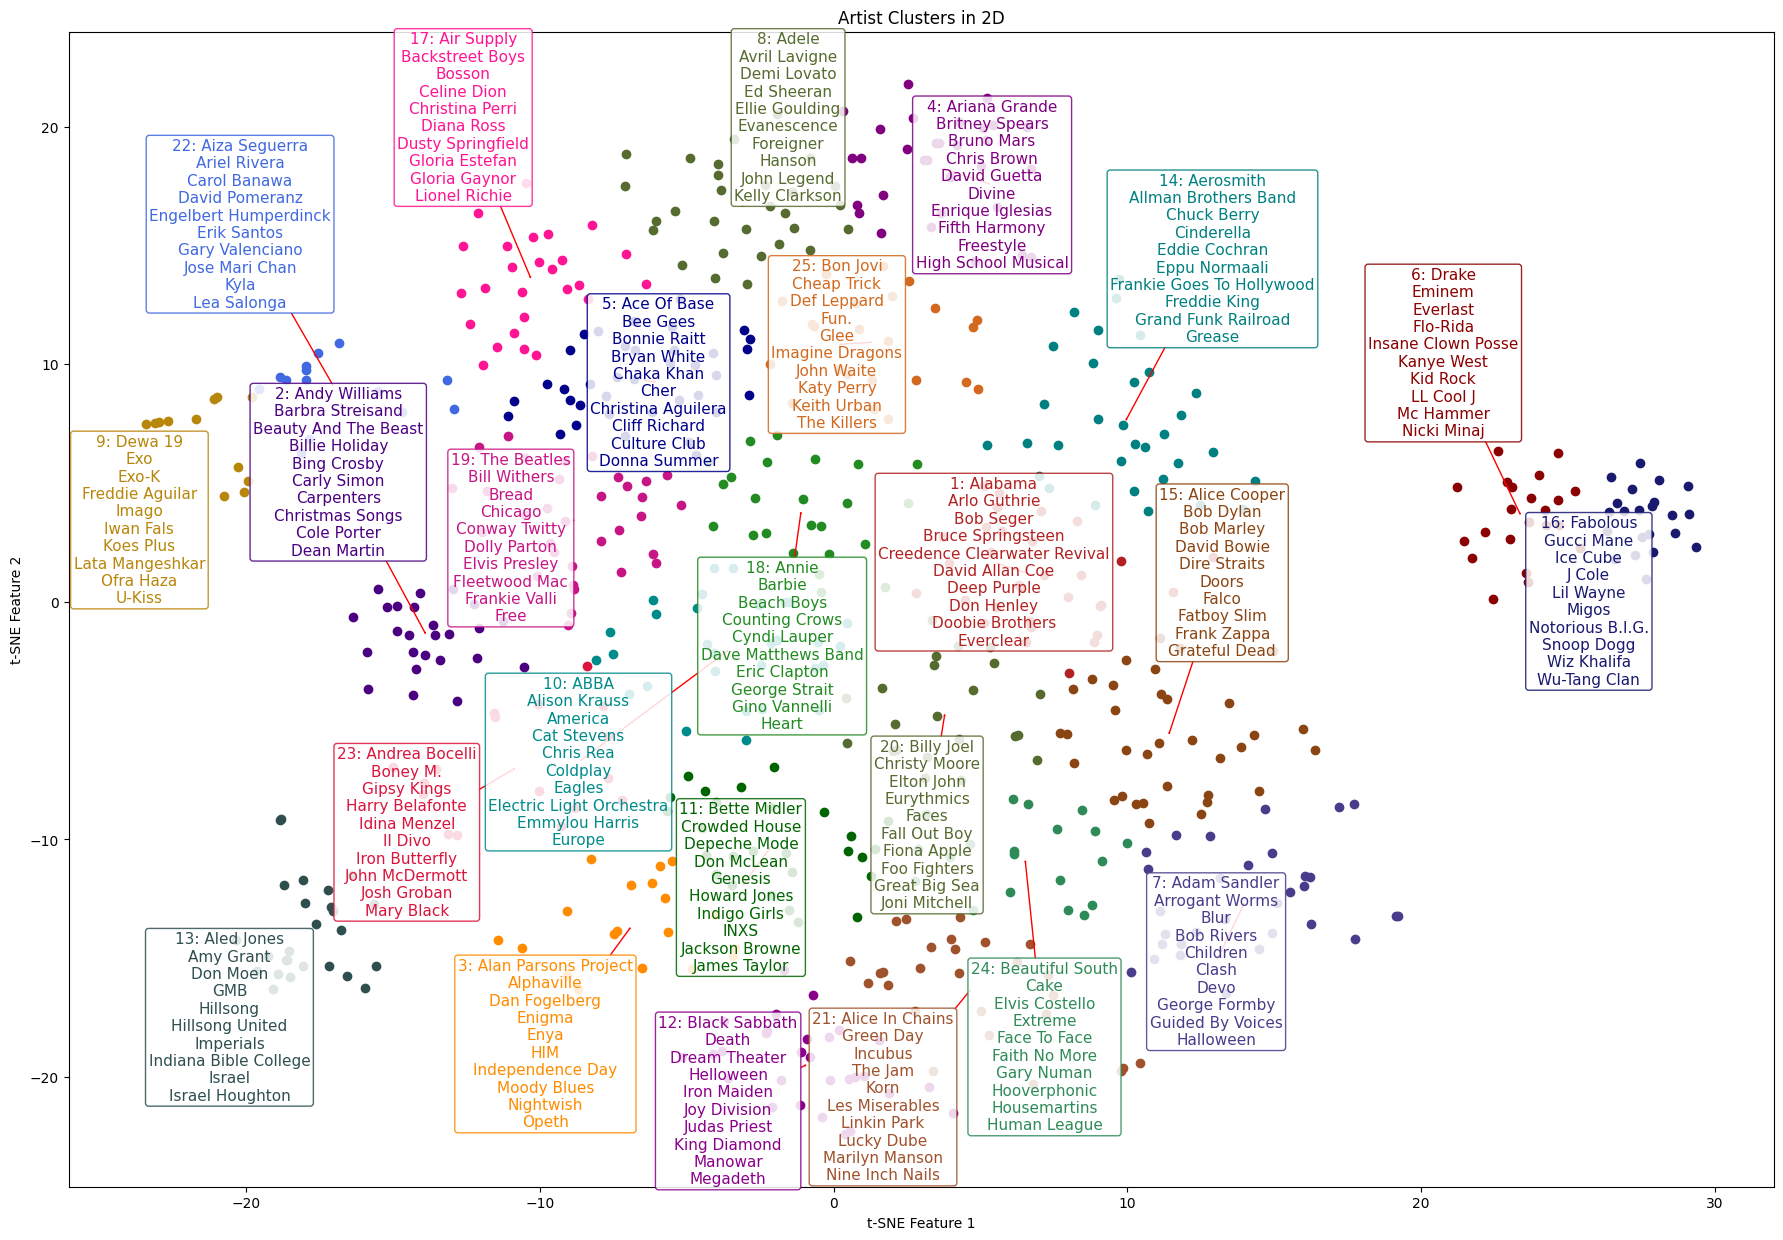

In [121]:
from random import choice

import numpy as np
from adjustText import adjust_text
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors


artist_vectors_list = list(artist_avg_vectors.values())
artist_vectors_np = np.array(artist_vectors_list)

tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(artist_vectors_np)

n_clusters = 25

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(reduced_vectors)
labels = kmeans.labels_

plt.figure(figsize=(22, 15))

colors = [
    'firebrick', 'indigo', 'darkorange',
    'purple', 'darkblue', 'darkred', 'darkslateblue', 'darkolivegreen',
    'darkgoldenrod', 'darkcyan', 'darkgreen', 'darkmagenta', 'darkslategray', 'teal',
    'saddlebrown', 'midnightblue', 'deeppink', 'forestgreen', 'mediumvioletred',
    'darkolivegreen', 'sienna', 'royalblue', 'crimson', 'seagreen',
    'chocolate', 'steelblue', 'darkkhaki', 'mediumblue', 'tomato',
    'cadetblue', 'maroon', 'darkblue', 'darkorange', 'darkgoldenrod', 'navy'
]

assert len(colors) >= n_clusters, "There are not enough colors for all clusters"

texts = []

for i in range(n_clusters):
    cluster_color = colors[i]
    
    cluster_indices = [index for index, label in enumerate(labels) if label == i]
    cluster_points = reduced_vectors[cluster_indices]
    scatter = plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i + 1}', color=colors[i])

    cluster_center = np.mean(cluster_points, axis=0)

    artists_in_cluster = [list(artist_avg_vectors.keys())[index] for index in cluster_indices]
    artists_text = '\n'.join(artists_in_cluster[:10])

    text = plt.text(
        cluster_center[0], 
        cluster_center[1], 
        f'{i + 1}: {artists_text}',
        ha='center', 
        fontsize=11,
        color=colors[i],
        bbox=dict(facecolor='white', alpha=0.85, edgecolor=colors[i], boxstyle='round,pad=0.2')  # Фон для текста
    )
    texts.append(text)

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

plt.title('Artist Clusters in 2D')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()

In [127]:
# COLLECTION_NAME_USERS = "users_collection"

def create_user_collection():
    if utility.has_collection(COLLECTION_NAME_USERS):
        utility.drop_collection(COLLECTION_NAME_USERS)

    # object should be inserted in the format of (artist, embedding embedding)
    fields = [
        FieldSchema(name="user_id", dtype=DataType.INT64, is_primary=True, auto_id=False),
        FieldSchema(name="embedding", dtype=DataType.FLOAT_VECTOR, dim=DIMENSION)
    ]
    
    schema = CollectionSchema(fields=fields)
    collection = Collection(name=COLLECTION_NAME_USERS, schema=schema)

    index_params = {
        "index_type": "IVF_FLAT",
        "metric_type": "L2",
        "params": {"nlist": 128},
    }
    collection.create_index(field_name="embedding", index_params=index_params)
    collection.load()
    return collection

collection_users = create_user_collection()

In [5]:
COLLECTION_NAME_USERS_ARTISTS = "users_artists_collection"

def create_user_artist_collection():
    if utility.has_collection(COLLECTION_NAME_USERS_ARTISTS):
        utility.drop_collection(COLLECTION_NAME_USERS_ARTISTS)

    fields = [
        FieldSchema(name="user_id", dtype=DataType.INT64, is_primary=True, auto_id=False),
        FieldSchema(name="embedding", dtype=DataType.FLOAT_VECTOR, dim=DIMENSION)
    ]
    
    schema = CollectionSchema(fields=fields)
    collection = Collection(name=COLLECTION_NAME_USERS_ARTISTS, schema=schema)

    index_params = {
        "index_type": "IVF_FLAT",
        "metric_type": "L2",
        "params": {"nlist": 128},
    }
    collection.create_index(field_name="embedding", index_params=index_params)
    collection.load()
    return collection

collection_users_artiss = create_user_artist_collection()

# RESEARCH

In [14]:
def create_songs_collection_part():
    if utility.has_collection(COLLECTION_NAME_SONGS_part):
        utility.drop_collection(COLLECTION_NAME_SONGS_part)

    fields = [
        FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=True),
        FieldSchema(name="artist", dtype=DataType.VARCHAR, max_length=100, partition_tag=True),  # Указываем ключ партиционирования
        FieldSchema(name="song", dtype=DataType.VARCHAR, max_length=100),
        FieldSchema(name="embedding", dtype=DataType.FLOAT_VECTOR, dim=DIMENSION)
    ]
    
    schema = CollectionSchema(fields=fields)
    collection = Collection(name=COLLECTION_NAME_SONGS_part, schema=schema)

    collection.create_index(field_name="embedding", 
                            index_params={
                                "index_type": "IVF_FLAT",
                                "metric_type": "L2",
                                "params": {"nlist": 128},
                            })    
    collection.load()
    return collection

In [15]:
collection_songs_part = create_songs_collection_part()

In [ ]:
def embed_insert_part(data, collection):
    try:
        texts = np.array(data[2])
        embeddings = transformer.encode(texts)

        insert_data = [
            data[0],  # artist
            data[1],  # song
            embeddings.tolist()  # embeddings
        ]

        collection.insert(insert_data, partition_name=data[0])
        print(f"Inserted batch of {len(data[0])} songs.")
        
        return {f"{artist}-{song}": embedding.tolist() for artist, song, embedding in zip(data[0], data[1], embeddings)}
    except Exception as e:
        print(f"Error during embedding and insertion: {e}")
        return None

In [ ]:
data_batch = [[], [], []]
song_vectors = {} 

for index, row in cleaned_df.iterrows():
    data_batch[0].append(row["artist"])
    data_batch[1].append(row["song"])
    data_batch[2].append(row["text"])

    if len(data_batch[0]) % BATCH_SIZE == 0:
        batch_vectors = embed_insert_part(data_batch, collection_songs_part)
        if batch_vectors is not None:
            song_vectors.update(batch_vectors)
        data_batch = [[], [], []]

if len(data_batch[0]) != 0:
    batch_vectors = embed_insert_part(data_batch, collection_songs_part)
    if batch_vectors is not None:
        song_vectors.update(batch_vectors)

try:
    songs_collection.flush()
    print("Flushed changes to the songs collection.")
except Exception as e:
    print(f"Error during flushing the songs collection: {e}")

In [17]:
data_batch = [[], [], []]
song_vectors = {} 

for index, row in cleaned_df.iterrows():
    data_batch[0].append(row["artist"])
    data_batch[1].append(row["song"])
    data_batch[2].append(row["text"])

    if len(data_batch[0]) % BATCH_SIZE == 0:
        batch_vectors = embed_insert_part(data_batch, collection_songs_part)
        if batch_vectors is not None:
            song_vectors.update(batch_vectors)
        data_batch = [[], [], []]

if len(data_batch[0]) != 0:
    batch_vectors = embed_insert_part(data_batch, collection_songs_part)
    if batch_vectors is not None:
        song_vectors.update(batch_vectors)

try:
    songs_collection.flush()
    print("Flushed changes to the songs collection.")
except Exception as e:
    print(f"Error during flushing the songs collection: {e}")

Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch of 512 songs.
Inserted batch